<a href="https://colab.research.google.com/github/yshubhaamm/machine-learning-project-1/blob/main/Spam_Detection_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install nltk

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
url = "https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv"
df = pd.read_csv(url, sep='\t', header=None, names=['label', 'message'])

In [3]:
df['label'] = df['label'].map({'ham': 0, 'spam': 1})
print(df.head())
print("\nLabel distribution:\n", df['label'].value_counts())


   label                                            message
0      0  Go until jurong point, crazy.. Available only ...
1      0                      Ok lar... Joking wif u oni...
2      1  Free entry in 2 a wkly comp to win FA Cup fina...
3      0  U dun say so early hor... U c already then say...
4      0  Nah I don't think he goes to usf, he lives aro...

Label distribution:
 label
0    4825
1     747
Name: count, dtype: int64


In [4]:
def clean_text(text):
    text = text.lower()  # Normalize case
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'https?://\S+|www\.\S+', ' link ', text)  # Replace links
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    tokens = text.split()
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    return " ".join(tokens)

df['cleaned'] = df['message'].apply(clean_text)

In [5]:
def count_links(text):
    return len(re.findall(r'http[s]?://\S+', text))

def count_uppercase(text):
    return sum(1 for word in text.split() if word.isupper())

def count_special_words(text):
    return len(re.findall(r'\b\w*\d\w*\b', text))  # Words with numbers

df['link_count'] = df['message'].apply(count_links)
df['uppercase_count'] = df['message'].apply(count_uppercase)
df['alphanumeric_words'] = df['message'].apply(count_special_words)

In [6]:
vectorizer = TfidfVectorizer()
X_text = vectorizer.fit_transform(df['cleaned'])

# Combine with manual features
X_manual = df[['link_count', 'uppercase_count', 'alphanumeric_words']].values
from scipy.sparse import hstack
X_combined = hstack([X_text, X_manual])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_combined, df['label'], test_size=0.2, random_state=42)


In [8]:
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Accuracy: 0.9820627802690582

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       966
           1       0.93      0.94      0.93       149

    accuracy                           0.98      1115
   macro avg       0.96      0.96      0.96      1115
weighted avg       0.98      0.98      0.98      1115



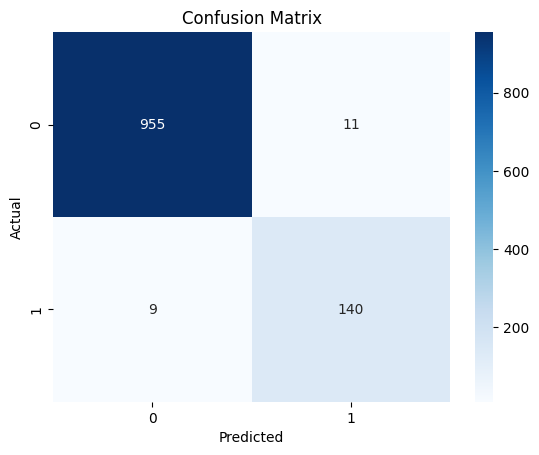

In [9]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()